## 概要
系(prior)が固定されている状況においては、main-networkとsub-networkの時間スケールに差がある場合の方が差がない場合に対してより最適に近いベイズ推定が実現することが示唆されている。

一方、priorが時間的に変化する場合における「対応力」(adjustability)に差があるのかについては明らかになっていない。
ここでは、一定時間経過後にpriorが変化するような状況を考え、その時の推論の様子を調べることで上記の問いを明らかにする。

priorの変化はまずは平均が変わる場合を調べたのち、分散が変わる場合を調べる。さらに、priorが時間変化する際の時間スケールに対する依存性も調べる。


In [82]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN, RNNSimple
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [101]:
def make_signal(N, time_length, state_list, uncertainty=0.5):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    g = 1.25
    target_list = np.zeros([N, 400])
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            if t <= 50:
                true_signal = state_list[0]()
            elif t <= 55:
                true_signal = state_list[1]()
            elif t <= 60:
                true_signal = state_list[0]()    
            elif t <= 65:
                true_signal = state_list[1]()
            elif t <= 70:
                true_signal = state_list[0]()    
            else:
                true_signal = state_list[1]()
            true_signal_list[i, t] = true_signal
            
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals, true_signal_list, signal_mu_list

In [102]:
def calc_bayesian_optimal(mu_l, sigma_l, mu_p, sigma_p):
    return mu_p * (sigma_l**2/(sigma_p**2+sigma_l**2)) + mu_l * (sigma_p**2/(sigma_p**2+sigma_l**2))

In [119]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220428_1/20220428_1.cfg'
# config_path = '../slow_reservoir/trained_model/dynamic_state_random_map/20220526_1/20220526_1.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_1 = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model_1.load_state_dict(torch.load(model_path, map_location=device))
model_1.eval()



model_name:  20220428_1


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [120]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220428_2/20220428_2.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_2 = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model_2.load_state_dict(torch.load(model_path, map_location=device))
model_2.eval()



model_name:  20220428_2


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [121]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220428_3/20220428_3.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_3 = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model_3.load_state_dict(torch.load(model_path, map_location=device))
model_3.eval()



model_name:  20220428_3


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [149]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220528_4/20220528_4.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    
model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_4 = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model_4.load_state_dict(torch.load(model_path, map_location=device))
model_4.eval()



model_name:  20220528_4


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [150]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220428_5/20220428_5.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    
model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_5 = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model_5.load_state_dict(torch.load(model_path, map_location=device))
model_5.eval()



model_name:  20220428_5


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [151]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220428_6/20220428_6.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    
model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model_6 = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model_6.load_state_dict(torch.load(model_path, map_location=device))
model_6.eval()



model_name:  20220428_6


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [152]:
state_list = [
    State(mu=-0.5, sigma=0.3),
    State(mu=0.5, sigma=0.3),
]

In [153]:
sample_num = 500
time_length = 200
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=time_length, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_1, prior_list, reservoir_list = model_1(inputs, hidden, reservoir, time_length)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_2, prior_list, reservoir_list = model_2(inputs, hidden, reservoir, time_length)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_3, prior_list, reservoir_list = model_3(inputs, hidden, reservoir, time_length)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_4, prior_list, reservoir_list = model_4(inputs, hidden, reservoir, time_length)          

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_5, prior_list, reservoir_list = model_5(inputs, hidden, reservoir, time_length)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_6, prior_list, reservoir_list = model_6(inputs, hidden, reservoir, time_length)                                                       



In [154]:
sigma_l = math.sqrt(1/1.25) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[0].mu, state_list[0].sigma,
)
bayesian_optimal_b = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[1].mu, state_list[1].sigma,
)


In [155]:
norm =  bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(100):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples_1 = (bayesian_optimal_b - np.array(outputs_1[:, :, 0].tolist())) / norm
alpha_samples_2 = (bayesian_optimal_b - np.array(outputs_2[:, :, 0].tolist())) / norm
alpha_samples_3 = (bayesian_optimal_b - np.array(outputs_3[:, :, 0].tolist())) / norm
alpha_samples_4 = (bayesian_optimal_b - np.array(outputs_4[:, :, 0].tolist())) / norm
alpha_samples_5 = (bayesian_optimal_b - np.array(outputs_5[:, :, 0].tolist())) / norm
alpha_samples_6 = (bayesian_optimal_b - np.array(outputs_6[:, :, 0].tolist())) / norm

alpha_1 = np.mean(alpha_samples_1, axis=0)
alpha_2 = np.mean(alpha_samples_2, axis=0)
alpha_3 = np.mean(alpha_samples_3, axis=0)
alpha_4 = np.mean(alpha_samples_4, axis=0)
alpha_5 = np.mean(alpha_samples_5, axis=0)
alpha_6 = np.mean(alpha_samples_6, axis=0)


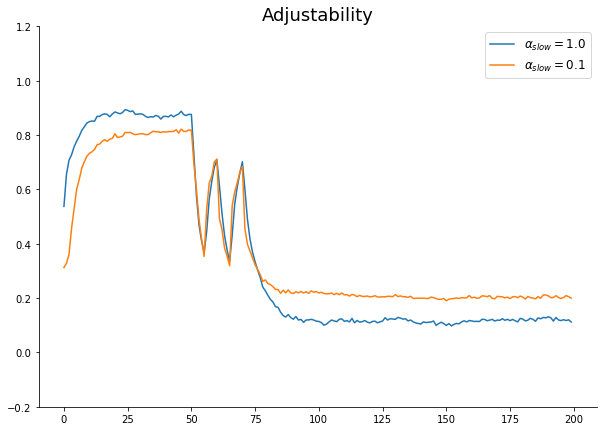

In [156]:
plt.figure(figsize=(10, 7))

plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
# plt.plot(alpha_2, label=r'$\alpha_{slow}=0.5$')
# plt.plot(alpha_3, label=r'$\alpha_{slow}=0.2$')
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$')
# plt.plot(alpha_5, label=r'$\alpha_{slow}=0.05$')
# plt.plot(alpha_6, label=r'$\alpha_{slow}=0.01$')
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
# plt.savefig('results/20220524/adjustability_3.png')
plt.show()

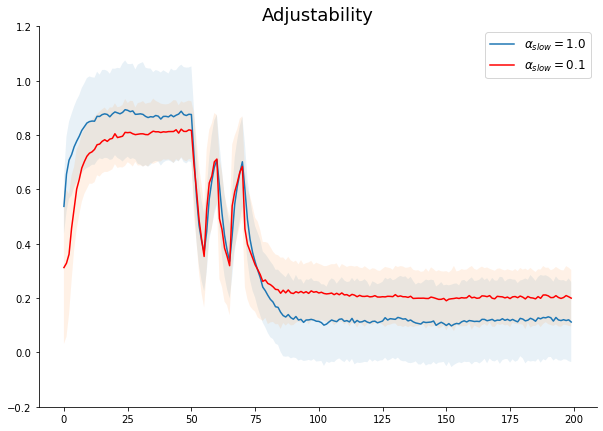

In [157]:
plt.figure(figsize=(10, 7))

time_length = 200
alpha_1_std = np.std(alpha_samples_1, axis=0)
alpha_4_std = np.std(alpha_samples_4, axis=0)
plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
plt.fill_between(range(time_length), alpha_1-alpha_1_std, alpha_1+alpha_1_std, alpha=.1)
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$', color='red')
plt.fill_between(range(time_length), alpha_4-alpha_4_std, alpha_4+alpha_4_std, alpha=.1)
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
# plt.savefig('results/20220531/adjustability_1.png')
plt.show()

In [17]:
state_list = [
    State(mu=0, sigma=0.8),
    State(mu=0, sigma=0.05),
]

In [18]:
sample_num = 500
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=100, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_1, prior_list, reservoir_list = model_1(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_2, prior_list, reservoir_list = model_2(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_3, prior_list, reservoir_list = model_3(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_4, prior_list, reservoir_list = model_4(inputs, hidden, reservoir, 100)          

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_5, prior_list, reservoir_list = model_5(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_6, prior_list, reservoir_list = model_6(inputs, hidden, reservoir, 100)                                                       



In [19]:
sigma_l = math.sqrt(1/1.25) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[0].mu, state_list[0].sigma,
)
bayesian_optimal_b = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[1].mu, state_list[1].sigma,
)


In [20]:
norm =  bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(100):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples_1 = (bayesian_optimal_b - np.array(outputs_1[:, :, 0].tolist())) / norm
alpha_samples_2 = (bayesian_optimal_b - np.array(outputs_2[:, :, 0].tolist())) / norm
alpha_samples_3 = (bayesian_optimal_b - np.array(outputs_3[:, :, 0].tolist())) / norm
alpha_samples_4 = (bayesian_optimal_b - np.array(outputs_4[:, :, 0].tolist())) / norm
alpha_samples_5 = (bayesian_optimal_b - np.array(outputs_5[:, :, 0].tolist())) / norm
alpha_samples_6 = (bayesian_optimal_b - np.array(outputs_6[:, :, 0].tolist())) / norm

alpha_1 = np.mean(alpha_samples_1, axis=0)
alpha_2 = np.mean(alpha_samples_2, axis=0)
alpha_3 = np.mean(alpha_samples_3, axis=0)
alpha_4 = np.mean(alpha_samples_4, axis=0)
alpha_5 = np.mean(alpha_samples_5, axis=0)
alpha_6 = np.mean(alpha_samples_6, axis=0)


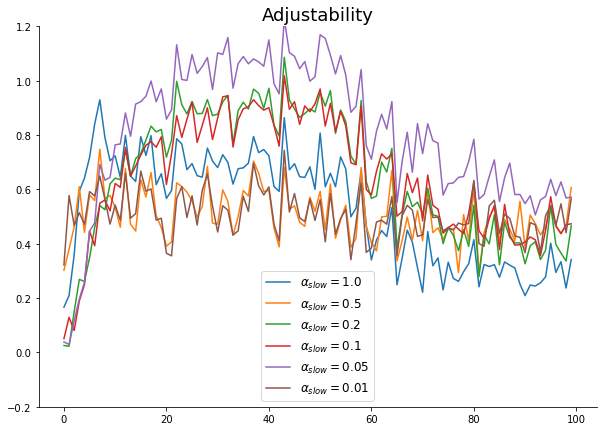

In [21]:
plt.figure(figsize=(10, 7))

plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
plt.plot(alpha_2, label=r'$\alpha_{slow}=0.5$')
plt.plot(alpha_3, label=r'$\alpha_{slow}=0.2$')
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$')
plt.plot(alpha_5, label=r'$\alpha_{slow}=0.05$')
plt.plot(alpha_6, label=r'$\alpha_{slow}=0.01$')
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
# plt.savefig('results/20220524/adjustability_5.png')
plt.show()

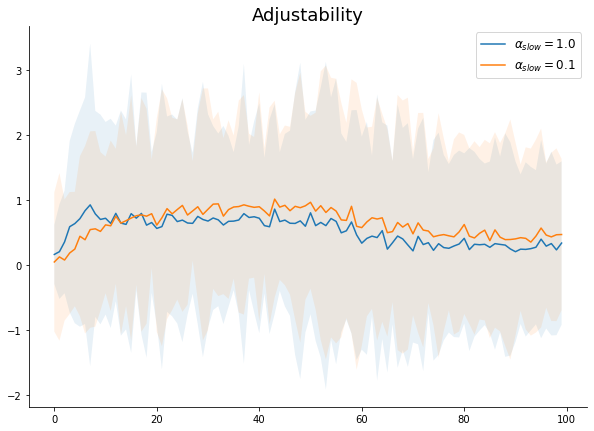

In [22]:
plt.figure(figsize=(10, 7))

alpha_1_std = np.std(alpha_samples_1, axis=0)
alpha_4_std = np.std(alpha_samples_4, axis=0)

plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
plt.fill_between(range(100), alpha_1-alpha_1_std, alpha_1+alpha_1_std, alpha=.1)
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$')
plt.fill_between(range(100), alpha_4-alpha_4_std, alpha_4+alpha_4_std, alpha=.1)
# plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
plt.show()

In [164]:
state_list = [
    State(mu=0., sigma=0.5),
    State(mu=0., sigma=0.1),
]

In [165]:
sample_num = 500
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=100, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_1, prior_list, reservoir_list = model_1(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_2, prior_list, reservoir_list = model_2(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_3, prior_list, reservoir_list = model_3(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_4, prior_list, reservoir_list = model_4(inputs, hidden, reservoir, 100)          

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_5, prior_list, reservoir_list = model_5(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_6, prior_list, reservoir_list = model_6(inputs, hidden, reservoir, 100)                                                       



In [166]:
sigma_l = math.sqrt(1/1.25) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[0].mu, state_list[0].sigma,
)
bayesian_optimal_b = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[1].mu, state_list[1].sigma,
)

In [167]:
norm =  bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(100):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples_1 = (bayesian_optimal_b - np.array(outputs_1[:, :, 0].tolist())) / norm
alpha_samples_2 = (bayesian_optimal_b - np.array(outputs_2[:, :, 0].tolist())) / norm
alpha_samples_3 = (bayesian_optimal_b - np.array(outputs_3[:, :, 0].tolist())) / norm
alpha_samples_4 = (bayesian_optimal_b - np.array(outputs_4[:, :, 0].tolist())) / norm
alpha_samples_5 = (bayesian_optimal_b - np.array(outputs_5[:, :, 0].tolist())) / norm
alpha_samples_6 = (bayesian_optimal_b - np.array(outputs_6[:, :, 0].tolist())) / norm

alpha_1 = np.mean(alpha_samples_1, axis=0)
alpha_2 = np.mean(alpha_samples_2, axis=0)
alpha_3 = np.mean(alpha_samples_3, axis=0)
alpha_4 = np.mean(alpha_samples_4, axis=0)
alpha_5 = np.mean(alpha_samples_5, axis=0)
alpha_6 = np.mean(alpha_samples_6, axis=0)


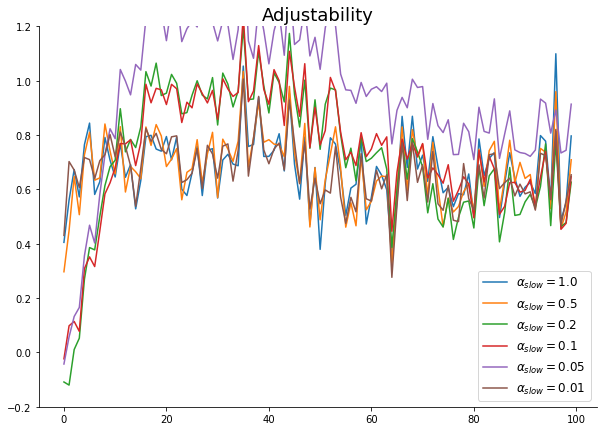

In [168]:
plt.figure(figsize=(10, 7))

plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
plt.plot(alpha_2, label=r'$\alpha_{slow}=0.5$')
plt.plot(alpha_3, label=r'$\alpha_{slow}=0.2$')
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$')
plt.plot(alpha_5, label=r'$\alpha_{slow}=0.05$')
plt.plot(alpha_6, label=r'$\alpha_{slow}=0.01$')
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
plt.show()

In [193]:
state_list = [
    State(mu=-0.5, sigma=0.7),
    State(mu=0.5, sigma=0.7),
]

In [194]:
sample_num = 500
input_signal, true_signal_list, signal_mu_list = make_signal(
    sample_num, 
    state_list=state_list,
    time_length=100, 
    uncertainty=0.5,
)

inputs = torch.from_numpy(input_signal).float()                                               
inputs = inputs.to(device) 

hidden_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(sample_num, cfg['MODEL']['RESERVOIR']))

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_1, prior_list, reservoir_list = model_1(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_2, prior_list, reservoir_list = model_2(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_3, prior_list, reservoir_list = model_3(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_4, prior_list, reservoir_list = model_4(inputs, hidden, reservoir, 100)          

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_5, prior_list, reservoir_list = model_5(inputs, hidden, reservoir, 100)

hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, outputs_6, prior_list, reservoir_list = model_6(inputs, hidden, reservoir, 100)                                                       



In [195]:
sigma_l = math.sqrt(1/1.25) * 0.5
bayesian_optimal_a = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[0].mu, state_list[0].sigma,
)
bayesian_optimal_b = calc_bayesian_optimal(
    signal_mu_list[:, :], sigma_l, state_list[1].mu, state_list[1].sigma,
)

In [196]:
norm =  bayesian_optimal_b - bayesian_optimal_a

for i in range(sample_num):
    for j in range(100):
        if abs(norm[i, j]) < 0.01:
            if norm[i, j] < 0:
                norm[i, j] = -0.01
            else:
                norm[i, j] = 0.01

alpha_samples_1 = (bayesian_optimal_b - np.array(outputs_1[:, :, 0].tolist())) / norm
alpha_samples_2 = (bayesian_optimal_b - np.array(outputs_2[:, :, 0].tolist())) / norm
alpha_samples_3 = (bayesian_optimal_b - np.array(outputs_3[:, :, 0].tolist())) / norm
alpha_samples_4 = (bayesian_optimal_b - np.array(outputs_4[:, :, 0].tolist())) / norm
alpha_samples_5 = (bayesian_optimal_b - np.array(outputs_5[:, :, 0].tolist())) / norm
alpha_samples_6 = (bayesian_optimal_b - np.array(outputs_6[:, :, 0].tolist())) / norm

alpha_1 = np.mean(alpha_samples_1, axis=0)
alpha_2 = np.mean(alpha_samples_2, axis=0)
alpha_3 = np.mean(alpha_samples_3, axis=0)
alpha_4 = np.mean(alpha_samples_4, axis=0)
alpha_5 = np.mean(alpha_samples_5, axis=0)
alpha_6 = np.mean(alpha_samples_6, axis=0)


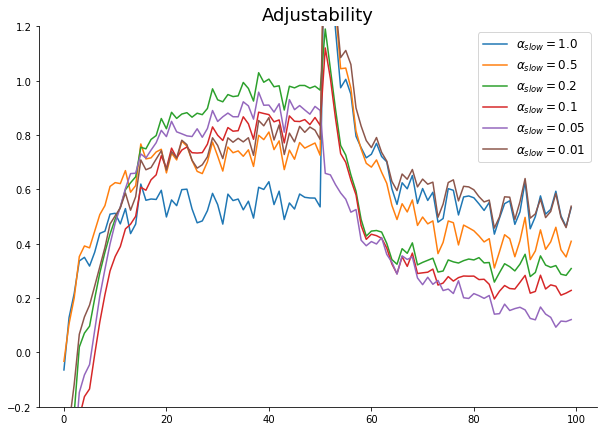

In [197]:
plt.figure(figsize=(10, 7))

plt.plot(alpha_1, label=r'$\alpha_{slow}=1.0$')
plt.plot(alpha_2, label=r'$\alpha_{slow}=0.5$')
plt.plot(alpha_3, label=r'$\alpha_{slow}=0.2$')
plt.plot(alpha_4, label=r'$\alpha_{slow}=0.1$')
plt.plot(alpha_5, label=r'$\alpha_{slow}=0.05$')
plt.plot(alpha_6, label=r'$\alpha_{slow}=0.01$')
plt.ylim([-0.2, 1.2])

plt.legend(fontsize=12)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.title('Adjustability', fontsize=18)
plt.savefig('results/20220524/adjustability_4.png')
plt.show()